In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('train.csv', index_col=0)

In [3]:
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,...,5.0,A,A,A,A,A,A,A,B,D
2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,...,NaN,A,A,C,A,B,A,A,C,A
3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,3,...,NaN,A,A,A,A,C,A,A,B,A
4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,0,...,5.0,C,A,A,A,A,D,A,A,A
5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,2,...,NaN,A,A,A,A,A,A,A,A,A


In [4]:
df.shape

(13730, 166)

# Primeiro vamos realizar uma análise exploratória dos dados, para compreender algumas questões.
    - Como estão distribuídas as notas por estado? 
    - As notas de quem fez a prova de língua estrangeira em inglês é maior em relação à quem fez em espanhol? 
    - A escolaridade dos pais do candidato influeciam na nota do candidato?
    - Como estão distribuídas as notas dos candidatos em função da renda mensal familiar? 
    - O sexo do candidato influencia na nota de matemática? 

In [5]:
df_notas_estado = df[['SG_UF_PROVA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']]
df_notas_estado.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
count,10341.000000,10341.000000,10133.000000,10133.000000
mean,473.495155,529.661087,516.472841,482.497928
std,71.093674,73.726344,68.688190,99.826323
min,0.000000,0.000000,0.000000,0.000000
25%,419.900000,480.400000,468.100000,408.900000
50%,459.800000,532.000000,520.900000,461.200000
75%,514.500000,581.200000,564.900000,537.600000
max,806.400000,807.000000,763.600000,952.000000


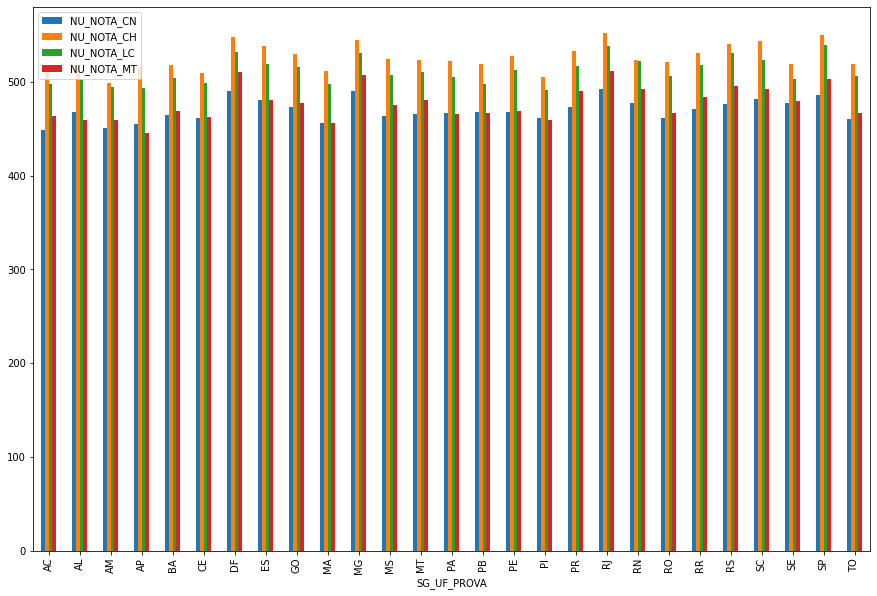

In [6]:
df_notas_estado.groupby('SG_UF_PROVA').mean().plot(kind='bar', figsize=(15, 10))

Levando em conta as informações como média, desvio padrão e o gráfico acima é plausível assumir que os estados não é um fator relevante para as médias em cada prova. Mesmo que as maiores médias estão presentes em DF, MG, RJ e SP.

In [7]:
df_notas_lingua = df[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA']].copy()
df_notas_lingua.describe()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA
count,10341.000000,10341.000000,10133.000000,10133.000000,13730.000000
mean,473.495155,529.661087,516.472841,482.497928,0.593664
std,71.093674,73.726344,68.688190,99.826323,0.491167
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.900000,480.400000,468.100000,408.900000,0.000000
50%,459.800000,532.000000,520.900000,461.200000,1.000000
75%,514.500000,581.200000,564.900000,537.600000,1.000000
max,806.400000,807.000000,763.600000,952.000000,1.000000


In [8]:
df_notas_lingua['TP_LINGUA'] = df_notas_lingua.loc[:, ('TP_LINGUA')].map({0: 'Inglês', 1: 'Espanhol'})

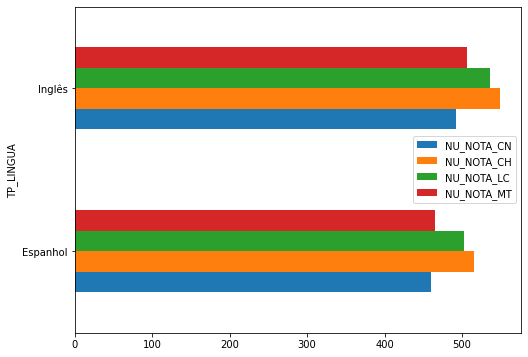

In [9]:
df_notas_lingua.groupby('TP_LINGUA').mean().plot(kind='barh', figsize=(8,6))

As notas dos candidatos com prova de língua estrangeira em inglês é ligeiramente maior em todas as áreas da prova.

In [10]:
(1 - (df_notas_lingua.groupby('TP_LINGUA').mean().iloc[0] / df_notas_lingua.groupby('TP_LINGUA').mean().iloc[1]))

NU_NOTA_CN    0.063860
NU_NOTA_CH    0.059747
NU_NOTA_LC    0.061553
NU_NOTA_MT    0.080587
dtype: float64

Agora vamos verificar as notas pela renda familiar

In [11]:
df_notas_renda = df[['Q006', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']]
df_notas_renda

,Q006,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
1,C,436.3,495.4,581.2,399.4,520.0
2,B,474.5,544.1,599.0,459.8,580.0
3,C,NaN,NaN,NaN,NaN,NaN
4,E,NaN,NaN,NaN,NaN,NaN
5,C,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4582,G,438.2,419.7,394.5,403.2,440.0
4583,C,423.8,557.9,533.0,452.4,560.0
4584,B,460.5,528.9,569.3,398.0,600.0
4585,G,422.5,621.7,569.0,386.6,460.0


In [12]:
df_notas_renda.loc[:, ('Q006')].value_counts()

B    4264
C    3641
D    1636
E    1028
F     667
G     642
A     491
H     433
I     253
J     165
N      97
K      93
P      68
O      66
Q      66
L      65
M      55
Name: Q006, dtype: int64

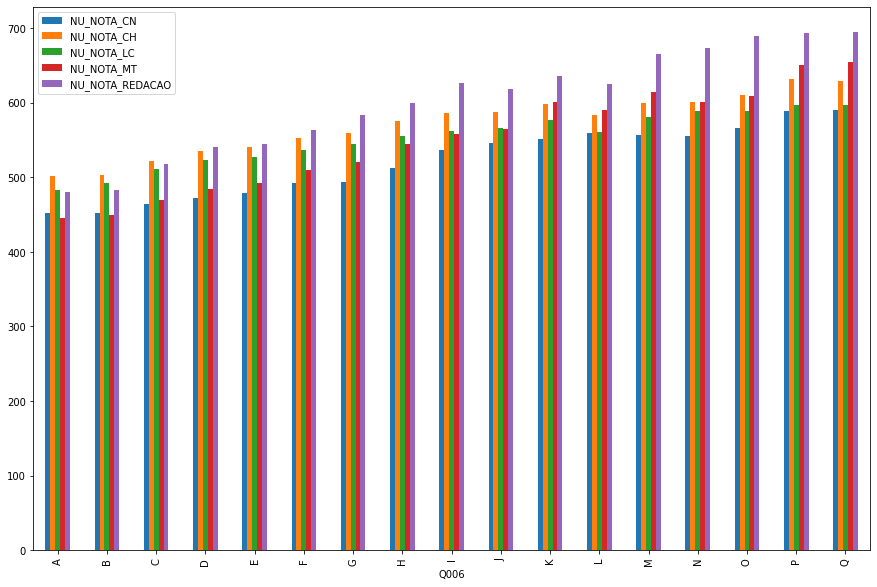

In [13]:
df_notas_renda.groupby('Q006').mean().plot(kind='bar', figsize=(15, 10))

A partir do gráfico é possível verificar que as médias das notas mudam em função da renda familiar. 

Pelo post abaixo podemos medir a correlação usando três formas diferentes, sendo elas: Point Biseral Correlation, Regressão Logística e Kruskal-Wallis H Test (Or parametric forms such as t-test or ANOVA).

ref: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

In [14]:
le = preprocessing.LabelEncoder()

In [15]:
# Realizando o label enconder em Q006
df_notas_renda.loc[:, ('Q006')] = le.fit_transform(df_notas_renda['Q006'])
df_notas_renda

/home/guilherme/anaconda3/envs/aceleradev-ds/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Q006,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
1,2,436.3,495.4,581.2,399.4,520.0
2,1,474.5,544.1,599.0,459.8,580.0
3,2,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN
5,2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4582,6,438.2,419.7,394.5,403.2,440.0
4583,2,423.8,557.9,533.0,452.4,560.0
4584,1,460.5,528.9,569.3,398.0,600.0
4585,6,422.5,621.7,569.0,386.6,460.0


Agora vamos tratar os valores nulos das features de notas. 

In [16]:
# Primeiro vamos verificar quem foi eliminado ou faltou e então atribuir o valor zero,
# o que faz sentido para o contexto do problema. 

df_notas_presenca = df[['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']]

In [17]:
# Para os eliminados, i.e., tp_presença = 2 temos:
df_notas_presenca.loc[:, ('NU_NOTA_CN')] = np.where(df_notas_presenca.loc[:, ('TP_PRESENCA_CN')] == 2, 0, df_notas_presenca['NU_NOTA_CN'])
df_notas_presenca.loc[:, ('NU_NOTA_CH')] = np.where(df_notas_presenca.loc[:, ('TP_PRESENCA_CH')] == 2, 0, df_notas_presenca['NU_NOTA_CH'])
df_notas_presenca.loc[:, ('NU_NOTA_LC')] = np.where(df_notas_presenca.loc[:, ('TP_PRESENCA_LC')] == 2, 0, df_notas_presenca['NU_NOTA_LC'])
df_notas_presenca.loc[:, ('NU_NOTA_MT')] = np.where(df_notas_presenca.loc[:, ('TP_PRESENCA_MT')] == 2, 0, df_notas_presenca['NU_NOTA_MT'])
df_notas_presenca.loc[:, ('NU_NOTA_REDACAO')] = np.where(df_notas_presenca.loc[:, ('TP_PRESENCA_MT')] == 2, 0, df_notas_presenca['NU_NOTA_REDACAO'])

/home/guilherme/anaconda3/envs/aceleradev-ds/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
df_notas_presenca[df_notas_presenca['TP_PRESENCA_MT'] == 2]

,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
546,1,1,2,2,565.5,533.4,0.0,0.0,0.0
1305,1,1,2,2,488.9,548.9,0.0,0.0,0.0
2080,1,1,2,2,425.4,578.3,0.0,0.0,0.0
2744,1,1,2,2,518.8,510.9,0.0,0.0,0.0
3114,1,1,2,2,576.7,659.7,0.0,0.0,0.0


In [19]:
# Olhando para os que faltaram, i.e., TP_PRESENÇA = 0
df_notas_presenca[df_notas_presenca['TP_PRESENCA_MT'] == 0].isnull().sum()

TP_PRESENCA_CN        0
TP_PRESENCA_CH        0
TP_PRESENCA_LC        0
TP_PRESENCA_MT        0
NU_NOTA_CN         3348
NU_NOTA_CH         3348
NU_NOTA_LC         3592
NU_NOTA_MT         3592
NU_NOTA_REDACAO    3592
dtype: int64

Olhando para os valores NaNs, verificamos que eles estão atrelados aos candidatos que faltaram à prova ou foram eliminados, portanto basta preencher por 0.

In [20]:
# Vamos verificar a correlação entre o sexo do candidato e as notas de matemática
df_sexo = df['TP_SEXO'].map({'M': 0, 'F': 1})
df_notas_presenca['NU_NOTA_MT'].fillna(0, inplace=True)

stats.ttest_ind(df_notas_presenca['NU_NOTA_MT'], df_sexo)

/home/guilherme/anaconda3/envs/aceleradev-ds/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Ttest_indResult(statistic=182.01301970806625, pvalue=0.0)

Assumindo como hipótese nula, H0, candidatos do sexo masculino e feminino tem a mesma média em matemática.
Como o p-value ficou abaixo do valor de significância estatística, 0.05, rejeitamos a hipótese nula. Portanto as médias do sexo são diferentes.

ref: 
https://statisticsbyjim.com/hypothesis-testing/comparing-hypothesis-tests-data-types/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Por fim, baseando-se na análise exploratória feita acima, as features iniciais são: 

In [21]:
features = ['NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO',
                 'TP_SEXO','TP_ESCOLA', 'TP_COR_RACA', 'Q001', 'Q002', 'Q006','Q047']

df_predict = df[features].copy()

In [22]:
df_predict.head()

,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_SEXO,TP_ESCOLA,TP_COR_RACA,Q001,Q002,Q006,Q047
1,24,436.3,495.4,581.2,399.4,520.0,M,1,1,D,D,C,A
2,17,474.5,544.1,599.0,459.8,580.0,F,2,3,A,A,B,A
3,21,NaN,NaN,NaN,NaN,NaN,F,1,3,D,D,C,A
4,25,NaN,NaN,NaN,NaN,NaN,F,1,0,H,E,E,D
5,28,NaN,NaN,NaN,NaN,NaN,M,1,2,E,D,C,A


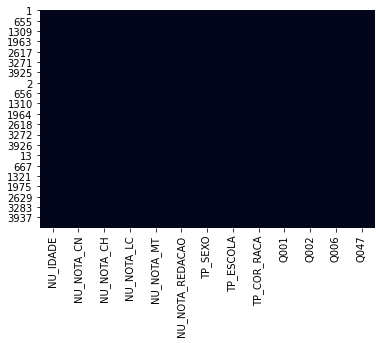

In [23]:
df_predict.fillna(0, inplace=True)

# Verificando a presença de nulos graficamente
sns.heatmap(df_predict.isnull(), cbar=False)

Refinando um pouco mais as features com Random Forests...

In [24]:
# Tratando as features categóricas... 
ft_cat = ['TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q047']

for ft in ft_cat:
    df_predict[ft] = pd.Categorical(df_predict[ft])
    df_predict[ft] = df_predict[ft].cat.codes

df_predict.head()

,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,TP_SEXO,TP_ESCOLA,TP_COR_RACA,Q001,Q002,Q006,Q047
1,24,436.3,495.4,581.2,399.4,520.0,1,1,1,3,3,2,0
2,17,474.5,544.1,599.0,459.8,580.0,0,2,3,0,0,1,0
3,21,0.0,0.0,0.0,0.0,0.0,0,1,3,3,3,2,0
4,25,0.0,0.0,0.0,0.0,0.0,0,1,0,7,4,4,3
5,28,0.0,0.0,0.0,0.0,0.0,1,1,2,4,3,2,0


In [25]:
# Separando as variaveis dependente e independente
y = df_predict['NU_NOTA_MT'].copy()
df_predict.drop(['NU_NOTA_MT'], axis=1, inplace=True)
X = df_predict.copy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [27]:
for index in range(0, len(df_predict.columns)):   
    print('feature: {} | importance: {}'.format(df_predict.columns[index],
                                             rf.feature_importances_[index]))

feature: NU_IDADE | importance: 0.006622758503485047
feature: NU_NOTA_CN | importance: 0.06288084515574928
feature: NU_NOTA_CH | importance: 0.021362489064676957
feature: NU_NOTA_LC | importance: 0.8772125060986914
feature: NU_NOTA_REDACAO | importance: 0.008053523362998284
feature: TP_SEXO | importance: 0.0022592513482040627
feature: TP_ESCOLA | importance: 0.0014981451898612847
feature: TP_COR_RACA | importance: 0.002814323925873166
feature: Q001 | importance: 0.00451474759920969
feature: Q002 | importance: 0.004680682732987062
feature: Q006 | importance: 0.006523076642656087
feature: Q047 | importance: 0.0015776503756077564


Dessa forma, deixaremos no modelo, somente as seguintes features: 
    - NU_NOTA_CN
    - NU_NOTA_CH
    - NU_NOTA_LC

In [49]:
features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']
df_predict = df[features].copy()
df_predict.fillna(0, inplace=True)

In [50]:
y = df_predict['NU_NOTA_MT'].copy()
df_predict.drop(['NU_NOTA_MT'], axis=1, inplace=True)
X = df_predict.copy()

# Testando alguns modelos de Machine Learning 

### Linear Regression

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

train_score = linear_reg.score(X_train, y_train)
test_score = linear_reg.score(X_test, y_test)
print('Train score: {:.4f} | Test score: {:.4f}'.format(train_score, test_score))

Train score: 0.9020 | Test score: 0.8982


### Polynomial Regression 

In [52]:
# Testando diferentes graus 
degrees = [1, 2, 3, 4, 5, 6, 7]

for degree in degrees:
    X_poly = preprocessing.PolynomialFeatures(degree).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y,random_state=0)
    linear_reg = LinearRegression().fit(X_train, y_train)
    
    train_score = linear_reg.score(X_train, y_train)
    test_score = linear_reg.score(X_test, y_test)
    
    print('Train score: {:.4f} | Test score: {:.4f} | degree: {}'.format(train_score, test_score, degree))

Train score: 0.9020 | Test score: 0.8982 | degree: 1
Train score: 0.9194 | Test score: 0.9163 | degree: 2
Train score: 0.9235 | Test score: 0.9205 | degree: 3
Train score: 0.9242 | Test score: 0.9212 | degree: 4
Train score: 0.9244 | Test score: 0.9208 | degree: 5
Train score: 0.9248 | Test score: 0.9210 | degree: 6
Train score: 0.9250 | Test score: 0.9197 | degree: 7


###  Lasso

In [53]:
# Utilizando diferentes valores para alpha
scaler = preprocessing.MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

values_alpha = [0.001, 0.01, 0.1, 1.0, 10, 100]

for alpha in values_alpha: 
    linlasso = Lasso(alpha=alpha).fit(X_train_scaled, y_train)

    train_score = linlasso.score(X_train_scaled, y_train)
    test_score = linlasso.score(X_test_scaled, y_test)
    print('Train score: {:.4f} | Test score: {:.4f} | alpha: {}'.format(train_score, test_score, alpha))

Train score: 0.9020 | Test score: 0.8982 | alpha: 0.001
Train score: 0.9020 | Test score: 0.8982 | alpha: 0.01
Train score: 0.9018 | Test score: 0.8982 | alpha: 0.1
Train score: 0.9010 | Test score: 0.8975 | alpha: 1.0
Train score: 0.8740 | Test score: 0.8704 | alpha: 10
Train score: 0.0000 | Test score: -0.0002 | alpha: 100


### Ridge

In [54]:
# Ridge
scaler = preprocessing.MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

values_alpha = [0.001, 0.01, 0.1, 1.0, 10, 100]

for alpha in values_alpha: 
    linridge = Ridge(alpha=alpha).fit(X_train_scaled, y_train)
    
    train_score = linridge.score(X_train_scaled, y_train)
    test_score = linridge.score(X_test_scaled, y_test)
    print('Train score: {:.4f} | Test score: {:.4f} | alpha: {}'.format(train_score, test_score, alpha))

Train score: 0.9020 | Test score: 0.8982 | alpha: 0.001
Train score: 0.9020 | Test score: 0.8982 | alpha: 0.01
Train score: 0.9020 | Test score: 0.8982 | alpha: 0.1
Train score: 0.9020 | Test score: 0.8982 | alpha: 1.0
Train score: 0.9014 | Test score: 0.8978 | alpha: 10
Train score: 0.8925 | Test score: 0.8888 | alpha: 100


O modelo escolhido é o Polynomial Regression com grau 4 devido ao seu score nos dados de teste

In [64]:
X_poly = preprocessing.PolynomialFeatures(3).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y,random_state=0)
linear_reg = LinearRegression().fit(X_train, y_train)

In [80]:
# Importando os dados de teste para submeter o desafio
df_test_data = pd.read_csv('test.csv')

df_answer = df_test_data[['NU_INSCRICAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']].copy()

In [81]:
df_answer.fillna(0, inplace=True)
df_answer.head()

,NU_INSCRICAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,464.8,443.5,431.8
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,391.1,491.1,548.0
2,b38a03232f43b11c9d0788abaf060f7366053b6d,595.9,622.7,613.6
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.0,0.0,0.0
4,715494628a50142ce8cb17191cfe6d0f3cae0934,592.9,492.6,571.4


In [82]:
X_values = preprocessing.PolynomialFeatures(3).fit_transform(df_answer[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']])

In [83]:
df_answer['NU_NOTA_MT'] = linear_reg.predict(X_values)

In [84]:
final_answer = df_answer[['NU_INSCRICAO', 'NU_NOTA_MT']].copy()

In [87]:
final_answer

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,430.292660
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,446.767825
2,b38a03232f43b11c9d0788abaf060f7366053b6d,599.275002
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.062581
4,715494628a50142ce8cb17191cfe6d0f3cae0934,540.241143
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,454.921720
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,463.287295
4573,655fa6306720ff16e825903b5422a46608a77545,654.653467
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,445.673768


In [86]:
final_answer.to_csv(r'/home/guilherme/codenation/enem-2/answer.csv', index=False)